### Data Set
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

# Data Preprocessing

In [1]:
import os
from distutils.dir_util import copy_tree
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import cv2

In [2]:
IMG_SIZE = 300

## Prepare Data

### Prepare Training Data

In [7]:
xtrain = []
ytrain = []

for file_name in os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL"):
#     img = cv2.imread(f"/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/{file_name}")
#     img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
#     img = img/255.0
#     img = img.reshape(1,IMG_SIZE,IMG_SIZE,3)
    img = image.load_img(f"../input/chest-xray-pneumonia/chest_xray/train/NORMAL/{file_name}", target_size=(IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    
    xtrain.append(img)
    ytrain.append(0)


for file_name in os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"):
    img = image.load_img(f"../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/{file_name}", target_size=(IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    
    xtrain.append(img)
    ytrain.append(1)

### Prepare Testing Data

In [8]:
xtest = []
ytest = []

for file_name in os.listdir("../input/chest-xray-pneumonia/chest_xray/test/NORMAL"):
#     img = cv2.imread(f"/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/{file_name}")
#     img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
#     img = img/255.0
#     img = img.reshape(1,IMG_SIZE,IMG_SIZE,3)
    img = image.load_img(f"../input/chest-xray-pneumonia/chest_xray/test/NORMAL/{file_name}", target_size=(IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    
    xtest.append(img)
    ytest.append(0)
    
for file_name in os.listdir("../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA"):
#     img = cv2.imread(f"/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/{file_name}")
#     img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
#     img = img/255.0
#     img = img.reshape(1,IMG_SIZE,IMG_SIZE,3)
    img = image.load_img(f"../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/{file_name}", target_size=(IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    
    xtest.append(img)
    ytest.append(1)

# Feature Extraction

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D, Dense, Dropout, Flatten, MaxPooling2D, Activation, BatchNormalization, TimeDistributed, AveragePooling2D, LSTM, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet152V2, MobileNetV2, DenseNet201, VGG19, DenseNet169, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [10]:
vgg_model = DenseNet169(weights="imagenet", include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
vgg_model.trainable = False ## Not trainable weights
# vgg_model.summary()

2022-12-03 07:38:14.338744: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


51888128/51877672 [==============================] - 0s 0us/step


In [11]:
xtrain_features = []
for i in range(len(xtrain)):
    xtrain_features.append(vgg_model.predict(xtrain[0]))
    del xtrain[0]
    
xtrain_features = np.array(xtrain_features)
xtrain_features = xtrain_features.reshape(xtrain_features.shape[0], -1)

2022-12-03 07:38:18.797436: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:
xtest_features = []
for i in range(len(xtest)):
    xtest_features.append(vgg_model.predict(xtest[0]))
    del xtest[0]
    
xtest_features = np.array(xtest_features)
xtest_features = xtest_features.reshape(xtest_features.shape[0], -1)

# Model Creation & Training

In [13]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

C=3.5 and gamma=0.000019 (densenet169)<br>
C=1.5 and gamma=0.000019 (resnet50)

In [14]:
model = SVC(C=1.5, gamma=0.000019, probability=True)
model.fit(xtrain_features, ytrain)

SVC(C=1.5, gamma=1.9e-05, probability=True)

In [15]:
model.score(xtrain_features, ytrain)

0.999808282208589

In [16]:
model.score(xtest_features, ytest)

0.8108974358974359

# Model Evaluation

## precision vs. recall and ROC

In [17]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
%matplotlib inline

In [18]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()

### Training Evaluation

In [19]:
pred = model.predict_proba(xtrain_features)
pred = np.max(pred, axis=1)
precisions, recalls, thresholds = precision_recall_curve(ytrain, pred)
fpr, tpr, thresholds2 = roc_curve(ytrain, pred)
print(f"Training AUC Score = {auc(fpr, tpr)}")

Training AUC Score = 0.8859887902624425


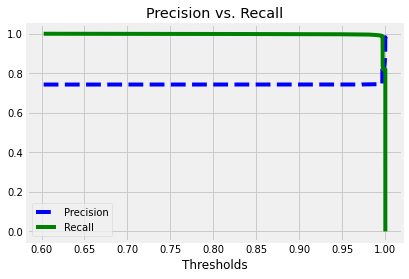

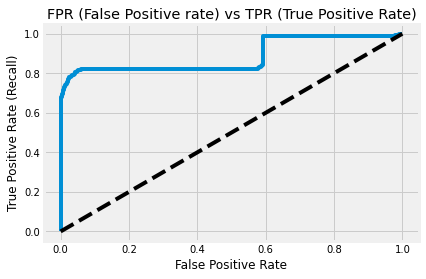

In [20]:
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [21]:
del pred
pred = model.predict(xtrain_features)
print('Accuracy on training set:', accuracy_score(ytrain, pred))
print('Precision on training set:', precision_score(ytrain, pred))
print('Recall on training set:', recall_score(ytrain, pred))

Accuracy on training set: 0.999808282208589
Precision on training set: 0.9997420020639834
Recall on training set: 1.0


[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Pneumonia')]

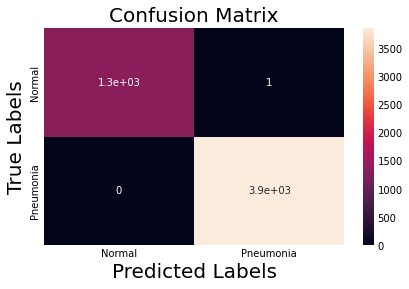

In [22]:
matrix = confusion_matrix(ytrain, pred)
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(["Normal","Pneumonia"])
ax.yaxis.set_ticklabels(["Normal","Pneumonia"])

### Testing Evaluation

In [23]:
pred = model.predict_proba(xtest_features)
pred = np.max(pred, axis=1)
precisions, recalls, thresholds = precision_recall_curve(ytest, pred)
fpr, tpr, thresholds2 = roc_curve(ytest, pred)
print(f"Testing AUC Score = {auc(fpr, tpr)}")

Testing AUC Score = 0.9350317773394696


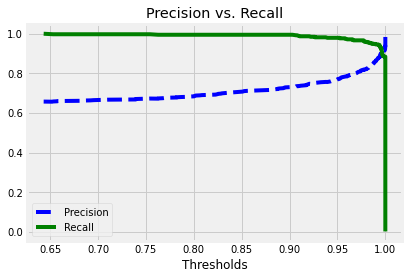

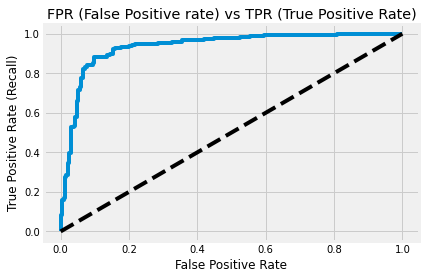

In [24]:
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [25]:
del pred
pred = model.predict(xtest_features)
print('Accuracy on testing set:', accuracy_score(ytest, pred))
print('Precision on testing set:', precision_score(ytest, pred))
print('Recall on testing set:', recall_score(ytest, pred))

Accuracy on testing set: 0.8108974358974359
Precision on testing set: 0.7677165354330708
Recall on testing set: 1.0


[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Pneumonia')]

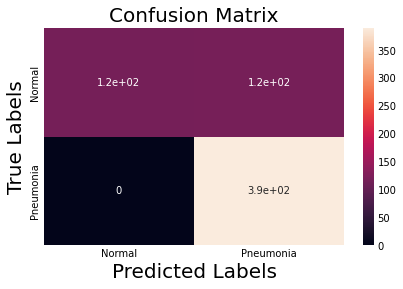

In [26]:
matrix = confusion_matrix(ytest, pred)
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels(["Normal","Pneumonia"])
ax.yaxis.set_ticklabels(["Normal","Pneumonia"])

## Save Model

In [ ]:
import pickle
pickle.dump("XRAY Model.pkl")